In [1]:
import sys
sys.path.insert(1, "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/")
import rijks_torch.learning_problems as lp
import rijks_torch.learning_problems.defaults as defs
from rijks_torch.data_loading import RijksDataloaders

import torch
from torchvision import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
out_path = "/home/vincent/Documenten/BachelorsProject/qualitative/"

In [3]:
# Getting the model

# Specify this, the rest is automatic :-)
ots = False

if ots: # Saved the best versions per experiment, so differrent ones here :-p
    version = "ots"
    model_idx = 2
else:
    version = "ft"
    model_idx = 0

state_dict = f"/home/vincent/Documenten/BachelorsProject/best_models/{version}_type{model_idx}_convnext_b{'' if ots else '_drop'}-best.pth"
dataset = f"/home/vincent/Documenten/BachelorsProject/Rijksdata/type/{model_idx}/fullsize"

datloader = RijksDataloaders(
    ds_name=dataset,
    hist_path=dataset + "-hist.csv",
    img_dir="/home/vincent/Documenten/BachelorsProject/Rijksdata/jpg/",
    transforms={"all": defs.buildTransform(imnet_norm=True)},
    batch_size=1
)

getmodel_fun = lp.get_convnext_b_problem if ots else lp.get_convnext_b_drop_problem
model, dl = getmodel_fun(off_the_shelf=False, pretrained=False, dl=datloader)
model.load_state_dict(torch.load(state_dict, map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
def outputAndGrad(model, im, im_cls=None):
    model.eval()
    im = im.unsqueeze(0)

    # Hook to get output
    outp = None
    def get_outp(_, __, out):
        nonlocal outp
        outp = out
    
    # Hook to get gradient:
    grad = None
    def get_grad(grd):
        nonlocal grad
        grad = grd
    
    # Forward:
    forward_handle = model.features[5].register_forward_hook(get_outp)
    prediction = model(im)
    p = torch.argmax(prediction)
    size = prediction.shape[1]

    # Pre-backward:
    backward_handle = outp.register_hook(get_grad)
    im_cls = im_cls if im_cls is not None else p
    one_hot = torch.zeros(size, dtype=torch.float)
    one_hot[im_cls] = 1
    one_hot = one_hot.unsqueeze(0)
    model.zero_grad()

    # Backward:
    prediction.backward(gradient=one_hot, retain_graph=True)

    # Post-backward:
    forward_handle.remove()
    backward_handle.remove() # Probably not needed, but still

    return outp[0].detach().numpy(), grad[0].detach().numpy(), p

In [5]:
def gradcam(model, im, im_cls=None):
    outp, grad, p = outputAndGrad(model, im, im_cls)

    weights = grad.mean(axis=(1,2)) # A weight for each channel

    cam = np.zeros(outp.shape[1:], dtype=np.float32)

    # Calculating weighted sum
    for w, act in zip(weights, outp):
        cam += w * act
    
    return cam, p

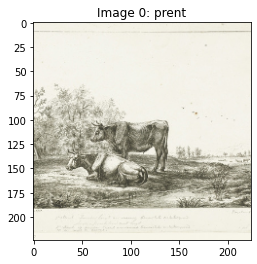

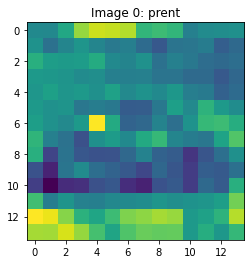

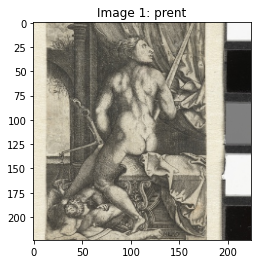

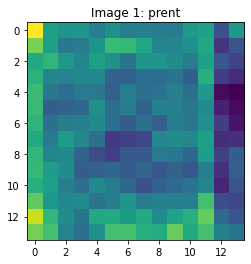

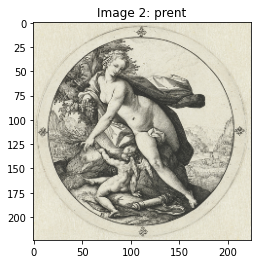

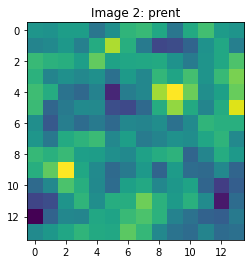

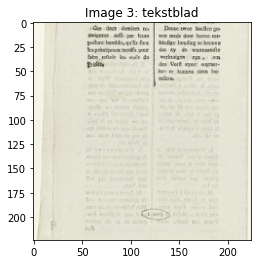

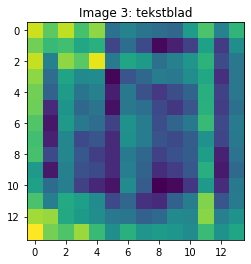

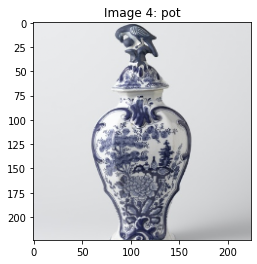

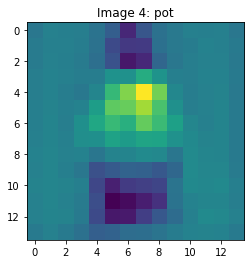

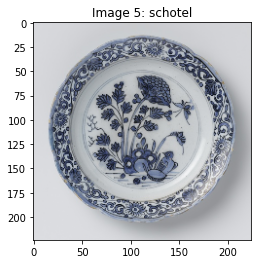

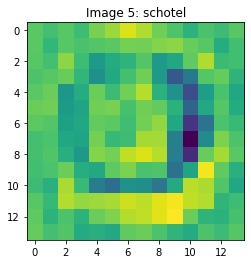

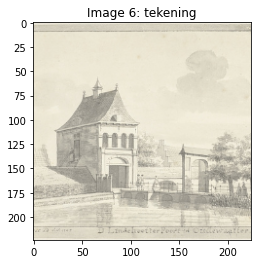

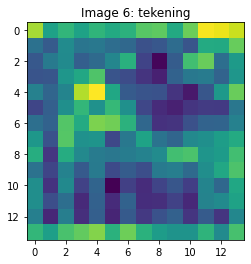

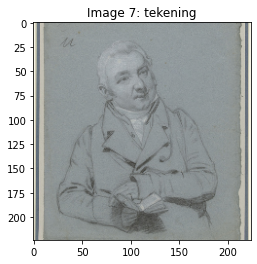

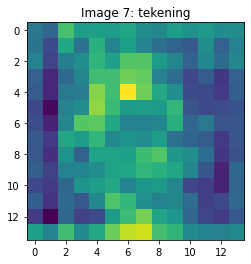

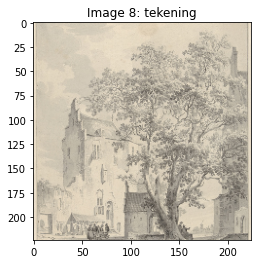

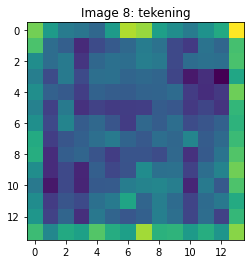

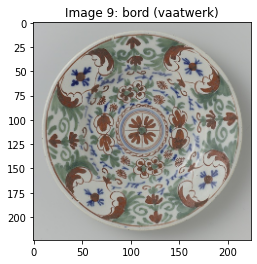

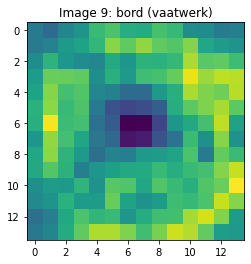

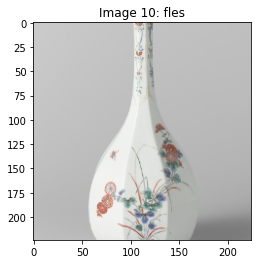

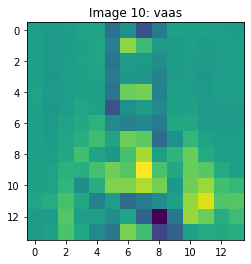

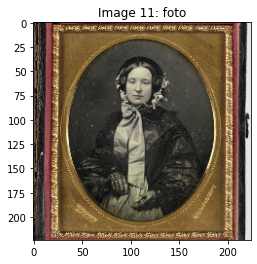

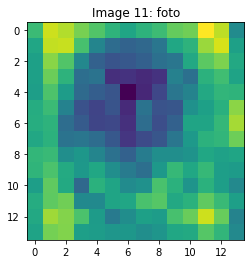

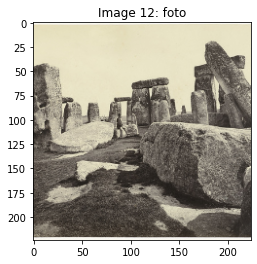

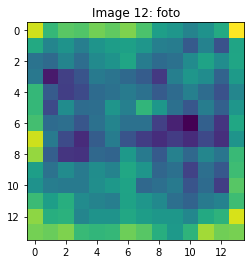

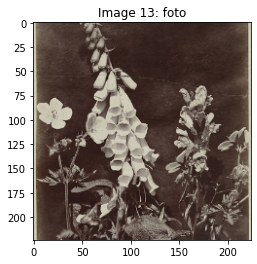

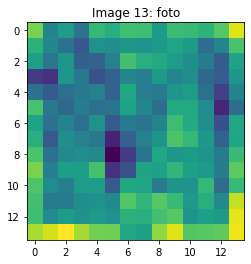

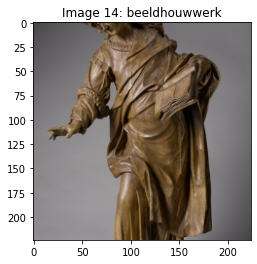

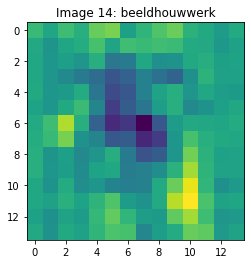

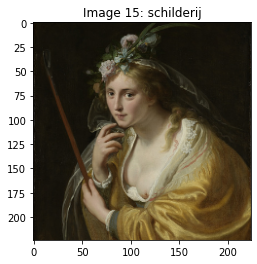

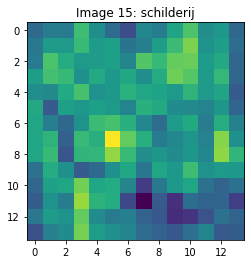

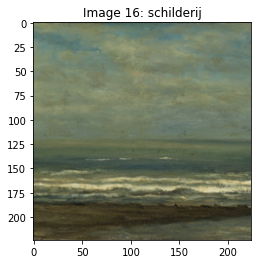

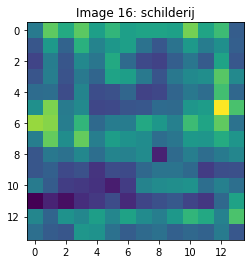

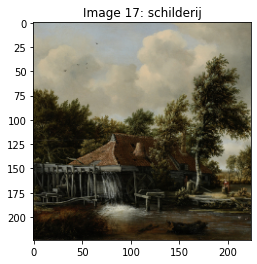

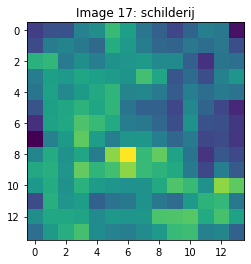

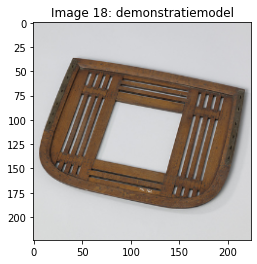

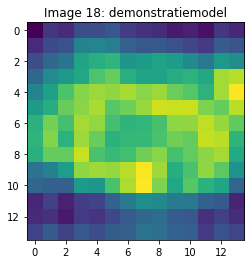

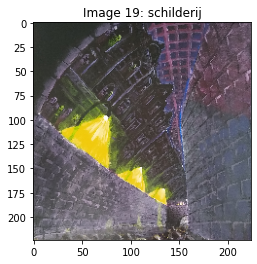

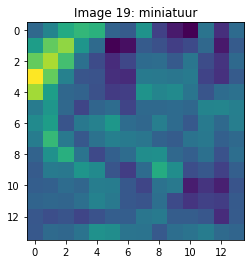

In [6]:
df = pd.read_csv("/home/vincent/Documenten/BachelorsProject/GitHub_Repo/data_annotations/qualitative.csv")

tfs = defs.buildTransform(imnet_norm=True)
tfsNoIM = defs.buildTransform(imnet_norm=False)

for idx, r in df.iterrows():
    im_name = "/home/vincent/Documenten/BachelorsProject/Rijksdata/jpg/" + r["jpg"]
    im_cls = dl.materials.index(r["material"])

    im = io.read_image(im_name, mode = io.ImageReadMode.RGB).float() / 255
    im = tfs(im)

    cam, prediction = gradcam(model, im)
    
    im = io.read_image(im_name, mode = io.ImageReadMode.RGB).float() / 255
    im = tfsNoIM(im).numpy().transpose(1,2,0)
    plt.imshow(im)
    plt.title(f"Image {idx}: {r['material']}")
    plt.show()

    plt.imshow(cam)
    plt.title(f"Image {idx}: {dl.materials[prediction]}")
    plt.show()

    prediction = dl.materials[prediction]
    np.save(out_path + f"convnext_{version}_img{idx:03}_saliency", cam)
    with open(out_path + f"convnext_{version}_img{idx:03}_prediction.txt", "w") as f:
        f.write(prediction)

